# Setup

In [ ]:
%%capture
!pip install transformers datasets pandas pyarrow torch scikit-learn --upgrade


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = 'drive/MyDrive/math319_project1'

Mounted at /content/drive


In [ ]:
from datasets import Dataset, DatasetDict, concatenate_datasets, load_dataset

import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import re
from tqdm.notebook import tqdm

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json


with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%capture
!kaggle competitions download -c child-mind-institute-detect-sleep-states
!unzip child-mind-institute-detect-sleep-states.zip
!rm -fr child-mind-institute-detect-sleep-states.zip sample_data/

In [ ]:
!ls

# Load Previous

In [ ]:
%%capture
with open(os.path.join(drive_path, 'series_ids.json'), 'r') as f:
  series_ids = json.load(f)



In [ ]:
dataset = DatasetDict.load_from_disk(os.path.join(drive_path, 'downsampled_dataset'))
dataset.save_to_disk('downsampled_dataset')
dataset = DatasetDict.load_from_disk('downsampled_dataset')

events = DatasetDict.load_from_disk(os.path.join(drive_path, 'events'))

In [ ]:
dataset = Dataset.from_csv(os.path.join(drive_path, 'train_ds_v2.csv'))
dataset.save_to_disk('train_dataset')
dataset = Dataset.load_from_disk('train_dataset')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/311907 [00:00<?, ? examples/s]

In [ ]:
dataset = load_dataset("Imxxn/child-mind-institute-v2")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/248400 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/63507 [00:00<?, ? examples/s]

In [ ]:
!du -sh ./

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'data'],
        num_rows: 248400
    })
    valid: Dataset({
        features: ['labels', 'data'],
        num_rows: 63507
    })
})

# Dataset Preprocess

In [ ]:
raw_dataset = Dataset.from_parquet('train_series.parquet')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
raw_dataset

Dataset({
    features: ['series_id', 'step', 'timestamp', 'anglez', 'enmo'],
    num_rows: 127946340
})

In [ ]:
series_ids = list(set(raw_dataset['series_id']))
len(series_ids)

277

In [ ]:
with open(os.path.join(drive_path, 'series_ids.json'), 'w') as file:
    json.dump(series_ids, file)

In [ ]:
def include_every_10(x):
  ans = []
  for step in x['step']:
      ans.append(step % 10 == 0)
  return ans

downsampled_dataset = raw_dataset.filter(include_every_10, batched=True, batch_size=500000)

Filter:   0%|          | 0/127946340 [00:00<?, ? examples/s]

In [ ]:
downsampled_dataset

Dataset({
    features: ['series_id', 'step', 'timestamp', 'anglez', 'enmo'],
    num_rows: 12794634
})

In [ ]:
from datasets import concatenate_datasets

dataset = {series_id: Dataset.from_list([]) for series_id in series_ids}

def build_sharded_dataset(examples):
  temp_ds = {series_id: [] for series_id in series_ids}

  for i in range(len(examples['series_id'])):
    series_id = examples['series_id'][i]
    temp_ds[series_id].append({
        'series_id': series_id,
        'step': examples['step'][i],
        'timestamp': examples['timestamp'][i],
        'anglez': examples['anglez'][i],
        'enmo': examples['enmo'][i]
    })

  for series_id, series in temp_ds.items():
    series = Dataset.from_list(series)
    dataset[series_id] = concatenate_datasets([dataset[series_id], series])


downsampled_dataset.map(build_sharded_dataset, batched=True, batch_size=200000)

Map:   0%|          | 0/12794634 [00:00<?, ? examples/s]

Dataset({
    features: ['series_id', 'step', 'timestamp', 'anglez', 'enmo'],
    num_rows: 12794634
})

In [ ]:
datasetdict = DatasetDict(dataset)

In [ ]:
datasetdict.save_to_disk(os.path.join(drive_path, 'downsampled_dataset'))

In [ ]:
datasetdict = DatasetDict(dataset)
datasetdict.push_to_hub("Imxxn/child-mind-institute", private=True)

In [ ]:
ds = Dataset.from_dict(raw_dataset[0:1000000]).filter(lambda x: x['series_id'] == '038441c925bb')
ds

Filter:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Dataset({
    features: ['series_id', 'step', 'timestamp', 'anglez', 'enmo'],
    num_rows: 389880
})

In [ ]:
ds[0:5]

{'series_id': ['038441c925bb',
  '038441c925bb',
  '038441c925bb',
  '038441c925bb',
  '038441c925bb'],
 'step': [0, 1, 2, 3, 4],
 'timestamp': ['2018-08-14T15:30:00-0400',
  '2018-08-14T15:30:05-0400',
  '2018-08-14T15:30:10-0400',
  '2018-08-14T15:30:15-0400',
  '2018-08-14T15:30:20-0400'],
 'anglez': [2.636699914932251,
  2.6368000507354736,
  2.63700008392334,
  2.6368000507354736,
  2.6368000507354736],
 'enmo': [0.021700000390410423,
  0.0215000007301569,
  0.02160000056028366,
  0.021299999207258224,
  0.0215000007301569]}

# Events Preprocess

In [ ]:
raw_events = Dataset.from_csv('train_events.csv')
raw_events

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['series_id', 'night', 'event', 'step', 'timestamp'],
    num_rows: 14508
})

In [ ]:
raw_events = raw_events.filter(lambda x: x['step'] is not None)
raw_events

Filter:   0%|          | 0/14508 [00:00<?, ? examples/s]

Dataset({
    features: ['series_id', 'night', 'event', 'step', 'timestamp'],
    num_rows: 9585
})

In [ ]:
a = raw_events.filter(lambda x: x['step'] == '390b487231ce')
a

Dataset({
    features: ['series_id', 'night', 'event', 'step', 'timestamp'],
    num_rows: 0
})

In [ ]:
raw_events[1]

{'series_id': '038441c925bb',
 'night': 1,
 'event': 'wakeup',
 'step': 10932.0,
 'timestamp': '2018-08-15T06:41:00-0400'}

In [ ]:
events = {series_id: Dataset.from_list([]) for series_id in series_ids}

def build_sharded_events(examples):
  temp_ds = {series_id: [] for series_id in series_ids}

  for i in range(len(examples['series_id'])):
    series_id = examples['series_id'][i]
    temp_ds[series_id].append({
        'series_id': series_id,
        'night': examples['night'][i],
        'event': examples['event'][i],
        'step': round(examples['step'][i] / 10) * 10,
        'timestamp': examples['timestamp'][i]
    })

  for series_id, series in temp_ds.items():
    series = Dataset.from_list(series)
    events[series_id] = concatenate_datasets([events[series_id], series])


raw_events.map(build_sharded_events, batched=True, batch_size=1000)

for k in list(events.keys()):
  if len(events[k]) == 0:
    del events[k]

events = DatasetDict(events)

Map:   0%|          | 0/9585 [00:00<?, ? examples/s]

In [ ]:
%%capture
events.save_to_disk(os.path.join(drive_path, 'events'))

In [ ]:
events

# Data Analysis

In [ ]:
raw_events = Dataset.from_csv('train_events.csv')
raw_events

Dataset({
    features: ['series_id', 'night', 'event', 'step', 'timestamp'],
    num_rows: 14508
})

In [ ]:
events = raw_events.filter(lambda x: x['series_id'] == '038441c925bb')
events = events.filter(lambda x: x['timestamp'] is not None)
events

Filter:   0%|          | 0/14508 [00:00<?, ? examples/s]

Filter:   0%|          | 0/46 [00:00<?, ? examples/s]

Dataset({
    features: ['series_id', 'night', 'event', 'step', 'timestamp'],
    num_rows: 38
})

In [ ]:
events[0:2]

{'series_id': ['038441c925bb', '038441c925bb'],
 'night': [1, 1],
 'event': ['onset', 'wakeup'],
 'step': [4992.0, 10932.0],
 'timestamp': ['2018-08-14T22:26:00-0400', '2018-08-15T06:41:00-0400']}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_time_series(series, events):
  # Generate some example accelerometer data (replace this with your actual data)
  # For this example, we're creating a sine wave with some noise
  np.random.seed(0)
  time_steps = series['timestamp']
  angles = series['anglez']
  enmo = series['enmo']
  event_times = events['timestamp']
  events = events['event']

  # Convert time_steps to datetime
  time_steps = pd.to_datetime(time_steps)

  # Convert event_times to datetime
  event_times = pd.to_datetime(event_times)

  # Create a DataFrame
  df = pd.DataFrame({
      'Angle_Z': angles,
      'ENMO': enmo
  }, index=time_steps)

  # Ensure the index is a DateTimeIndex, it should already be if the conversion was successful
  df.index = pd.to_datetime(df.index)

  # Now we can resample the data for plotting purposes
  df_resampled = df.resample('5T').mean()  # Resample to 5-minute intervals and take the mean

  # Plotting the data and events
  plt.figure(figsize=(15, 7))

  # Plot "Angle_Z"
  plt.subplot(2, 1, 1)
  plt.plot(df_resampled.index, df_resampled['Angle_Z'], label='Angle Z', color='blue')
  plt.title('Angle Z Over Time')
  plt.xlabel('Time')
  plt.ylabel('Angle (degrees)')

  # Add vertical lines for events on "Angle_Z"
  for etime, event in zip(event_times, events):
      color = 'blue' if event == 'onset' else 'red'
      plt.axvline(x=etime, color=color, linestyle='--', alpha=0.8)

  plt.legend()

  # Plot "ENMO"
  plt.subplot(2, 1, 2)
  plt.plot(df_resampled.index, df_resampled['ENMO'], label='ENMO', color='red')
  plt.title('ENMO Over Time')
  plt.xlabel('Time')
  plt.ylabel('ENMO (g)')

  # Add vertical lines for events on "ENMO"
  for etime, event in zip(event_times, events):
      color = 'blue' if event == 'onset' else 'red'
      plt.axvline(x=etime, color=color, linestyle='--', alpha=0.8)  # No need for label here, it's the same event

  plt.legend()

  plt.tight_layout()
  plt.show()

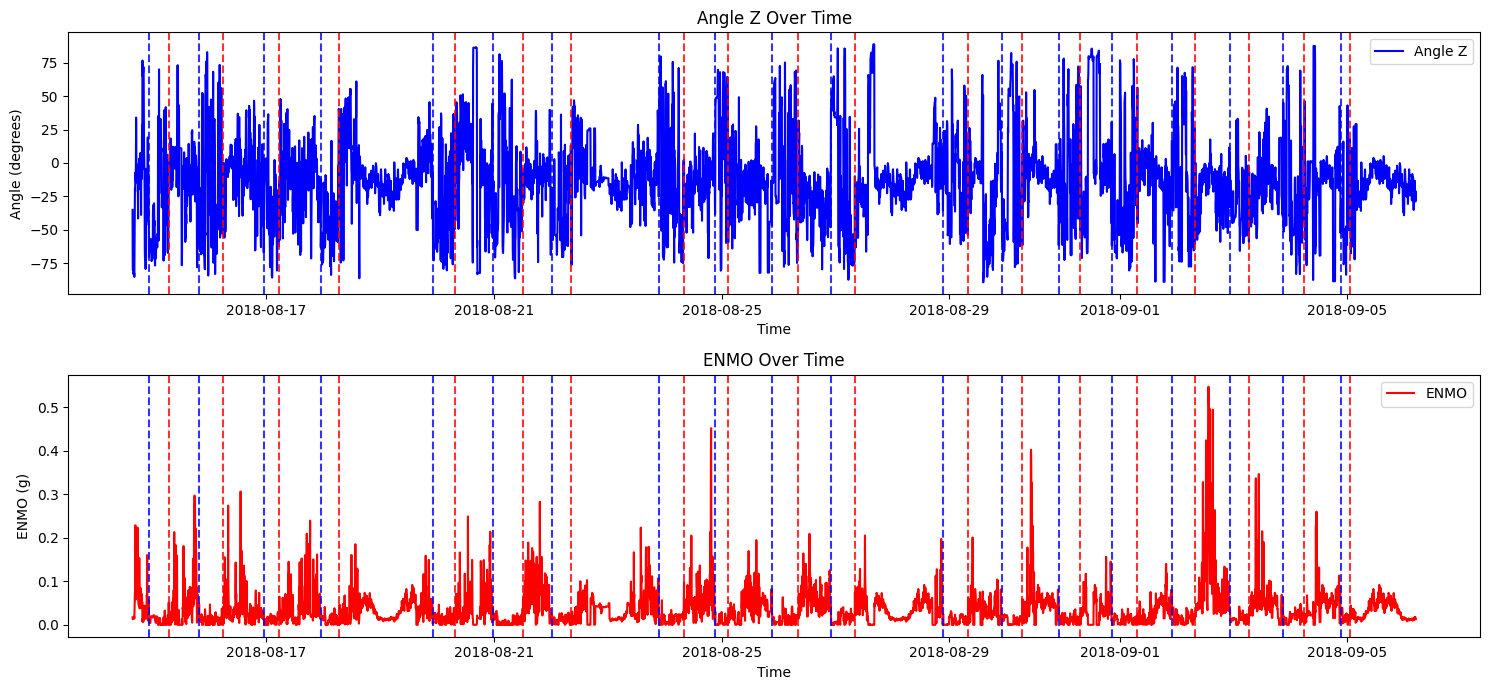

In [ ]:
# 1 full example
# red = onset
# blue = wakeup
plot_time_series(ds, events)

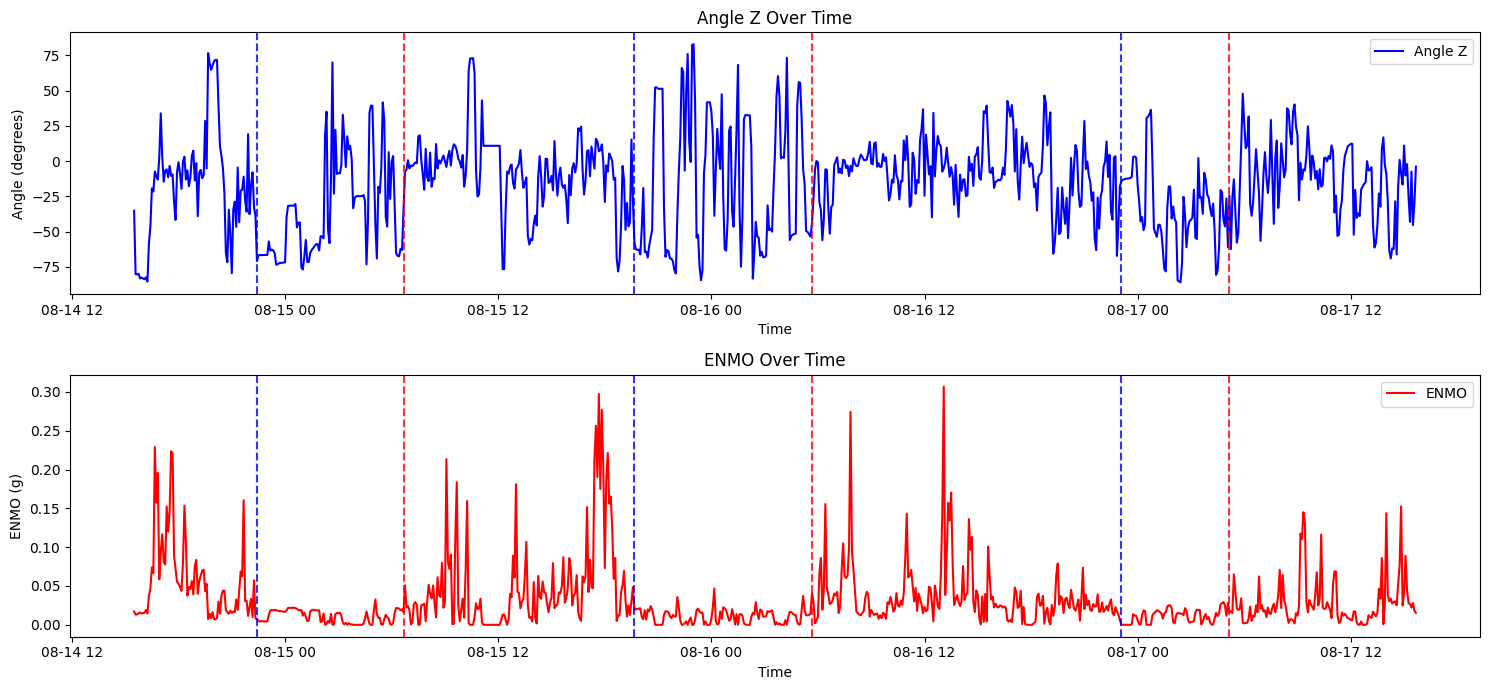

In [ ]:
# over 3 days
plot_time_series(Dataset.from_dict(ds[0:52000]), Dataset.from_dict(events[0:6]))

# Feature Engineering

In [ ]:
def parse_timestamp(timestamp):
    # Parse the timestamp
    dt = datetime.strptime(timestamp[:-5], "%Y-%m-%dT%H:%M:%S")
    tz_offset_hours = int(timestamp[-5:-2])
    tz_offset_minutes = int(timestamp[-2:])
    tz_offset = timedelta(hours=tz_offset_hours, minutes=tz_offset_minutes)

    if timestamp[-6] == '-':
        tz_offset = -tz_offset

    return {
        "year": dt.year,
        "month": dt.month,
        "day": dt.day,
        "hour": dt.hour,
        "minute": dt.minute,
        "second": dt.second,
        "timezone_offset": int(tz_offset.total_seconds() / 60) # in minutes
    }


In [ ]:
ds = dataset['154fe824ed87']
ds

Dataset({
    features: ['series_id', 'step', 'anglez', 'enmo', 'year', 'month', 'day', 'hour', 'minute', 'second', 'timezone_offset'],
    num_rows: 55224
})

In [ ]:
parse_timestamp(ds[0]['timestamp'])

{'year': 2019,
 'month': 1,
 'day': 26,
 'hour': 14,
 'minute': 30,
 'second': 0,
 'timezone_offset': -300}

In [ ]:
def update_timestamp(example):
  updated_time = parse_timestamp(example['timestamp'])
  for k, v in updated_time.items():
    example[k] = v
  return example

def update_timestamps(examples):
  for i in range(len(examples['series_id'])):
    updated_time = parse_timestamp(examples['timestamp'][i])
    for k, v in updated_time.items():
      if k not in examples:
        examples[k] = []
      examples[k].append(v)
  return examples

# refeatured_ds = ds.map(update_timestamps, remove_columns=['timestamp'], batched=True, batch_size=50000)

In [ ]:
e[-1]

{'series_id': '154fe824ed87',
 'night': 31,
 'event': 'wakeup',
 'step': 532260,
 'timestamp': '2019-02-26T09:45:00-0500'}

In [ ]:
e = events['154fe824ed87']
e

Dataset({
    features: ['series_id', 'night', 'event', 'step', 'timestamp'],
    num_rows: 61
})

In [ ]:
def build_train_dataset(dataset, events, window_size=5):
  X = []
  Y = []
  n = len(dataset['enmo'])
  for i in range(window_size, n - window_size, 2 * window_size):
    step = dataset['step'][i]
    x = list([
      float(dataset['step'][i]),
      float(dataset['year'][i]),
      float(dataset['month'][i]),
      float(dataset['hour'][i]),
      float(dataset['minute'][i]),
      float(dataset['second'][i]),
      float(dataset['timezone_offset'][i]),
    ]) + dataset['anglez'][i - window_size:i + window_size] + dataset['enmo'][i - window_size:i + window_size]

    idx = -1
    for j, s in enumerate(events['step']):
      if step - (10 * window_size) <= s < step + (10 * window_size):
        idx = events['step'].index(s)
        break

    if idx == -1:
      y = 0
    else:
      if events['event'][idx] == 'onset':
        y = 1
      else:
        y = 2

    X.append(x)
    Y.append(y)

  return X, Y

X, Y = build_train_dataset(refeatured_ds.remove_columns('series_id').to_dict(), e, 20)

In [ ]:
Y[1330]

2

In [ ]:
len(X[1330])

87

In [ ]:
for k in tqdm(dataset.keys(), desc='Processing:'):
  dataset[k] = dataset[k].map(update_timestamps, remove_columns=['timestamp'], batched=True, batch_size=50000)

In [ ]:
train_dataset = []
train_labels = []

for k in tqdm(events.keys(), desc='Datasets: '):
  ds = dataset[k]
  e = events[k]
  X, Y = build_train_dataset(ds.remove_columns('series_id').to_dict(), e, window_size=20)
  train_dataset += X
  train_labels += Y

Datasets:   0%|          | 0/269 [00:00<?, ?it/s]

In [ ]:
train_dataset[1]

In [ ]:
print(len(train_dataset))
print(len(train_labels))

311907
311907


In [ ]:
w = 20 # window size
column_names = ['step', 'year', 'month', 'hour', 'minute', 'second', 'timezone_offset'] + \
  [f'anglez_minus_{abs(i)}' for i in range(-w, 0, 1)] + ['anglez_current'] + \
  [f'anglez_plus_{i}' for i in range(1, w, 1)] + \
  [f'enmo_minus_{abs(i)}' for i in range(-w, 0, 1)] + ['enmo_current'] + \
  [f'enmo_plus_{i}' for i in range(1, w, 1)] + ['labels']
len(column_names)

88

In [ ]:
print(column_names)

['step', 'year', 'month', 'hour', 'minute', 'second', 'timezone_offset', 'anglez_minus_20', 'anglez_minus_19', 'anglez_minus_18', 'anglez_minus_17', 'anglez_minus_16', 'anglez_minus_15', 'anglez_minus_14', 'anglez_minus_13', 'anglez_minus_12', 'anglez_minus_11', 'anglez_minus_10', 'anglez_minus_9', 'anglez_minus_8', 'anglez_minus_7', 'anglez_minus_6', 'anglez_minus_5', 'anglez_minus_4', 'anglez_minus_3', 'anglez_minus_2', 'anglez_minus_1', 'anglez_current', 'anglez_plus_1', 'anglez_plus_2', 'anglez_plus_3', 'anglez_plus_4', 'anglez_plus_5', 'anglez_plus_6', 'anglez_plus_7', 'anglez_plus_8', 'anglez_plus_9', 'anglez_plus_10', 'anglez_plus_11', 'anglez_plus_12', 'anglez_plus_13', 'anglez_plus_14', 'anglez_plus_15', 'anglez_plus_16', 'anglez_plus_17', 'anglez_plus_18', 'anglez_plus_19', 'enmo_minus_20', 'enmo_minus_19', 'enmo_minus_18', 'enmo_minus_17', 'enmo_minus_16', 'enmo_minus_15', 'enmo_minus_14', 'enmo_minus_13', 'enmo_minus_12', 'enmo_minus_11', 'enmo_minus_10', 'enmo_minus_9', 'e

In [ ]:
for i in range(len(train_dataset)):
  train_dataset[i].append(train_labels[i])

In [ ]:
len(train_dataset[0])

88

In [ ]:
import csv

In [ ]:
with open('train_ds_v2.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(column_names)

    # Write the data
    buffer = 1000
    for i in tqdm(range(0, len(train_dataset), buffer)):
      writer.writerows(train_dataset[i:i+buffer])

  0%|          | 0/312 [00:00<?, ?it/s]

In [ ]:
!cp train_ds_v2.csv drive/MyDrive/math319_project1/train_ds_v2.csv

In [ ]:
!wc -l drive/MyDrive/math319_project1/train_ds_v2.csv

311908 drive/MyDrive/math319_project1/train_ds_v2.csv


In [ ]:
train_columns = ['step', 'year', 'month', 'hour', 'minute', 'second', 'timezone_offset', 'anglez_minus_20', 'anglez_minus_19', 'anglez_minus_18', 'anglez_minus_17', 'anglez_minus_16', 'anglez_minus_15', 'anglez_minus_14', 'anglez_minus_13', 'anglez_minus_12', 'anglez_minus_11', 'anglez_minus_10', 'anglez_minus_9', 'anglez_minus_8', 'anglez_minus_7', 'anglez_minus_6', 'anglez_minus_5', 'anglez_minus_4', 'anglez_minus_3', 'anglez_minus_2', 'anglez_minus_1', 'anglez_current', 'anglez_plus_1', 'anglez_plus_2', 'anglez_plus_3', 'anglez_plus_4', 'anglez_plus_5', 'anglez_plus_6', 'anglez_plus_7', 'anglez_plus_8', 'anglez_plus_9', 'anglez_plus_10', 'anglez_plus_11', 'anglez_plus_12', 'anglez_plus_13', 'anglez_plus_14', 'anglez_plus_15', 'anglez_plus_16', 'anglez_plus_17', 'anglez_plus_18', 'anglez_plus_19', 'enmo_minus_20', 'enmo_minus_19', 'enmo_minus_18', 'enmo_minus_17', 'enmo_minus_16', 'enmo_minus_15', 'enmo_minus_14', 'enmo_minus_13', 'enmo_minus_12', 'enmo_minus_11', 'enmo_minus_10', 'enmo_minus_9', 'enmo_minus_8', 'enmo_minus_7', 'enmo_minus_6', 'enmo_minus_5', 'enmo_minus_4', 'enmo_minus_3', 'enmo_minus_2', 'enmo_minus_1', 'enmo_current', 'enmo_plus_1', 'enmo_plus_2', 'enmo_plus_3', 'enmo_plus_4', 'enmo_plus_5', 'enmo_plus_6', 'enmo_plus_7', 'enmo_plus_8', 'enmo_plus_9', 'enmo_plus_10', 'enmo_plus_11', 'enmo_plus_12', 'enmo_plus_13', 'enmo_plus_14', 'enmo_plus_15', 'enmo_plus_16', 'enmo_plus_17', 'enmo_plus_18', 'enmo_plus_19']

def reduce_columns(examples):
  examples['data'] = []
  for i in range(len(examples['step'])):
    examples['data'].append([examples[v][i] for v in train_columns])
  return examples

temp_dataset = dataset.map(reduce_columns, remove_columns=train_columns, batched=True, batch_size=10000)

Map:   0%|          | 0/311907 [00:00<?, ? examples/s]

In [ ]:
temp_dataset.push_to_hub('Imxxn/child-mind-institute-v2', private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/312 [00:00<?, ?ba/s]

In [ ]:
temp_dataset

Dataset({
    features: ['labels', 'data'],
    num_rows: 311907
})

In [ ]:
50.0 == 50.0

True

In [ ]:
start_indexes = []

def print_start_indices(examples, indexes):
  for i in range(len(examples['data'])):
    if examples['data'][i][0] == 200.0:
      start_indexes.append(indexes[i])
      print(f"{len(start_indexes) - 1}: {indexes[i]}")


temp_dataset.map(print_start_indices, with_indices=True, batched=True, batch_size=5000)

Map:   0%|          | 0/311907 [00:00<?, ? examples/s]

0: 0
1: 1380
2: 1983
3: 4278
4: 4767
5: 5689
6: 7319
7: 8351
8: 8940
9: 9972
10: 10879
11: 11859
12: 13452
13: 14511
14: 15565
15: 16982
16: 17987
17: 19016
18: 20076
19: 21137
20: 22346
21: 23369
22: 24383
23: 25364
24: 26342
25: 27631
26: 28580
27: 29522
28: 30372
29: 31374
30: 32966
31: 34040
32: 35566
33: 35907
34: 36908
35: 38500
36: 39478
37: 40460
38: 41492
39: 42534
40: 42822
41: 43815
42: 44784
43: 45773
44: 46933
45: 48795
46: 49765
47: 50804
48: 52347
49: 53253
50: 54326
51: 55287
52: 56387
53: 57105
54: 58702
55: 59642
56: 61321
57: 61413
58: 62437
59: 63505
60: 64842
61: 65835
62: 67346
63: 68778
64: 70016
65: 71036
66: 71942
67: 72897
68: 73783
69: 74751
70: 75752
71: 76802
72: 77844
73: 78920
74: 79890
75: 81316
76: 82820
77: 83799
78: 84827
79: 85879
80: 86894
81: 87834
82: 88833
83: 90168
84: 91204
85: 92304
86: 93716
87: 94709
88: 95670
89: 96678
90: 97666
91: 98648
92: 99616
93: 100812
94: 102498
95: 103527
96: 104595
97: 105609
98: 105949
99: 107001
100: 108260
101:

Dataset({
    features: ['labels', 'data'],
    num_rows: 311907
})

In [ ]:
start_indexes[-50:][0]

248400

In [ ]:
def filter_train(examples, indexes):
  res = []
  for i in range(len(examples['labels'])):
    res.append(indexes[i] < 248400)
  return res

def filter_test(examples, indexes):
  res = []
  for i in range(len(examples['labels'])):
    res.append(indexes[i] >= 248400)
  return res

train_split = temp_dataset.filter(filter_train, with_indices=True, batched=True, batch_size=10000)
test_split = temp_dataset.filter(filter_test, with_indices=True, batched=True, batch_size=10000)

Filter:   0%|          | 0/311907 [00:00<?, ? examples/s]

Filter:   0%|          | 0/311907 [00:00<?, ? examples/s]

In [ ]:
train_split

Dataset({
    features: ['labels', 'data'],
    num_rows: 248400
})

In [ ]:
test_split

Dataset({
    features: ['labels', 'data'],
    num_rows: 63507
})

In [ ]:
dataset = DatasetDict({
    'train': train_split,
    'valid': test_split
})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'data'],
        num_rows: 248400
    })
    valid: Dataset({
        features: ['labels', 'data'],
        num_rows: 63507
    })
})

In [ ]:
dataset.push_to_hub('Imxxn/child-mind-institute-v2', private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/249 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/64 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/320 [00:00<?, ?B/s]

# Model

## XGBoost

In [ ]:
!pip install xgboost --upgrade

In [ ]:
import xgboost as xgb

# For a classification problem
model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, seed=123)

# For a regression problem
# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=123)


In [ ]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=100, n_informative=15, n_classes=3, random_state=42)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost multi-class classifier
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, n_estimators=1000, seed=123, verbosity=2)

# Train the model
model.fit(X_train, y_train, verbose=True)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.69


In [ ]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

## Neural Network

In [ ]:
import random

In [ ]:
count = {0: 0, 1: 0, 2: 0}

def count_fn(examples):
  for x in examples['labels']:
    count[x] += 1

dataset['train'].map(count_fn, batched=True, batch_size=10000)
count

Map:   0%|          | 0/248400 [00:00<?, ? examples/s]

{0: 240536, 1: 7864, 2: 0}

In [ ]:
def change_labels_to_detect(examples):
  for i in range(len(examples['labels'])):
    examples['labels'][i] = 0 if examples['labels'][i] == 0 else 1
  return examples

dataset['train'] = dataset['train'].map(change_labels_to_detect, batched=True, batch_size=10000)
dataset['valid'] = dataset['valid'].map(change_labels_to_detect, batched=True, batch_size=10000)

Map:   0%|          | 0/248400 [00:00<?, ? examples/s]

Map:   0%|          | 0/63507 [00:00<?, ? examples/s]

In [ ]:
def include_only_readings(examples):
  for i in range(len(examples['labels'])):
    examples['data'][i] = examples['data'][i][:40]
  return examples

dataset['train'] = dataset['train'].map(include_only_readings, batched=True, batch_size=10000)
dataset['valid'] = dataset['valid'].map(include_only_readings, batched=True, batch_size=10000)

Map:   0%|          | 0/248400 [00:00<?, ? examples/s]

Map:   0%|          | 0/63507 [00:00<?, ? examples/s]

In [ ]:
len(dataset['train'][10000]['data'])

40

In [ ]:
dataset

In [ ]:
def filter_unimportant(examples):
  res = []
  for i in range(len(examples['labels'])):
    res.append(examples['labels'][i] != 0 or random.random() < 0.1)
  return res

dataset['train'] = dataset['train'].filter(filter_unimportant, batched=True, batch_size=10000)
dataset['valid'] = dataset['valid'].filter(filter_unimportant, batched=True, batch_size=10000)

Filter:   0%|          | 0/248400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/63507 [00:00<?, ? examples/s]

In [ ]:
count = {0: 0, 1: 0, 2: 0}
dataset['train'].map(count_fn, batched=True, batch_size=10000)
count

Map:   0%|          | 0/248400 [00:00<?, ? examples/s]

{0: 240536, 1: 7864, 2: 0}

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import torch.nn.functional as F

In [ ]:
BATCH_SIZE = 4096
LEARNING_RATE = 0.0001
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [ ]:
def calculate_f1_score(outputs, labels):
  _, predicted = torch.max(outputs, 1)

  predicted = predicted.cpu().numpy()
  labels = labels.cpu().numpy()

  return f1_score(labels, predicted, labels=[0, 1], average=None)

In [ ]:
class SuperNN(nn.Module):
  def __init__(self):
    super(SuperNN, self).__init__()
    self.fc1 = nn.Linear(40, 256)
    self.bn1 = nn.BatchNorm1d(256)
    self.dropout1 = nn.Dropout(0.5)

    self.fc2 = nn.Linear(256, 256)
    self.bn2 = nn.BatchNorm1d(256)
    self.dropout2 = nn.Dropout(0.5)

    self.fc3 = nn.Linear(256, 128)
    self.bn3 = nn.BatchNorm1d(128)
    self.dropout3 = nn.Dropout(0.5)

    self.fc4 = nn.Linear(128, 128)
    self.bn4 = nn.BatchNorm1d(128)
    self.dropout4 = nn.Dropout(0.5)

    self.fc5 = nn.Linear(128, 128)
    self.bn5 = nn.BatchNorm1d(128)
    self.dropout5 = nn.Dropout(0.5)

    self.fc6 = nn.Linear(128, 64)
    self.bn6 = nn.BatchNorm1d(64)
    self.dropout6 = nn.Dropout(0.5)

    self.fc7 = nn.Linear(64, 64)
    self.bn7 = nn.BatchNorm1d(64)
    self.dropout7 = nn.Dropout(0.5)

    self.fc8 = nn.Linear(64, 32)
    self.bn8 = nn.BatchNorm1d(32)
    self.dropout8 = nn.Dropout(0.5)

    self.fc_out = nn.Linear(32, 2)

  def forward(self, x):
    x = F.relu(self.bn1(self.fc1(x)))
    x = self.dropout1(x)

    x = F.relu(self.bn2(self.fc2(x)))
    x = self.dropout2(x)

    x = F.relu(self.bn3(self.fc3(x)))
    x = self.dropout3(x)

    x = F.relu(self.bn4(self.fc4(x)))
    x = self.dropout4(x)

    x = F.relu(self.bn5(self.fc5(x)))
    x = self.dropout5(x)

    x = F.relu(self.bn6(self.fc6(x)))
    x = self.dropout6(x)

    x = F.relu(self.bn7(self.fc7(x)))
    x = self.dropout7(x)

    x = F.relu(self.bn8(self.fc8(x)))
    x = self.dropout8(x)

    x = self.fc_out(x)
    return x

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  inputs = torch.tensor([item['data'] for item in batch])
  labels = torch.tensor([item['labels'] for item in batch])
  return inputs, labels

train_dataloader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset['valid'], batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [ ]:
model = SuperNN()

model = model.to(DEVICE)

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

158882

In [ ]:
weights = torch.tensor([1.0, 50.0]).to(DEVICE) # punish more if it gets the important labels wrong
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  total_f1 = [0., 0.]
  train_dataloader = tqdm(train_dataloader)
  for inputs, labels in train_dataloader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()  # Zero the gradient buffers
    outputs = model(inputs)  # Forward pass
    loss = criterion(outputs, labels)
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    total_loss += loss.item()
    f1 = calculate_f1_score(outputs, labels)
    total_f1 += f1
    # print(f'Loss: {loss.item()}, f1 score: {f1}')

  avg_train_loss = total_loss / len(train_dataloader)
  avg_train_f1 = total_f1 / len(train_dataloader)
  print(f'Average Training Loss: {avg_train_loss}, Average F1 Score: {avg_train_f1}')

  val_dataloader = tqdm(val_dataloader)
  model.eval()
  total_val_loss = 0
  total_val_f1 = [0., 0.]
  with torch.no_grad():
    for inputs, labels in val_dataloader:
      inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_val_loss += loss.item()
      f1 = calculate_f1_score(outputs, labels)
      total_val_f1 += f1

    avg_val_loss = total_val_loss / len(val_dataloader)
    avg_val_f1 = total_val_f1 / len(val_dataloader)
    print(f'Average Validation Loss: {avg_val_loss}, Average Validation F1 Score: {avg_val_f1}')


print('Finished Training')


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.7429196004007683, Average F1 Score: [0.58539975 0.06188074]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.6898466795682907, Average Validation F1 Score: [0.91357448 0.10062437]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.7147549361479087, Average F1 Score: [0.56738686 0.06485159]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7075096592307091, Average Validation F1 Score: [0.98617961 0.00351169]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.697861123280447, Average F1 Score: [0.55683298 0.06694506]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7194993384182453, Average Validation F1 Score: [0.98647877 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.682229859907119, Average F1 Score: [0.5591074  0.07092107]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7276037223637104, Average Validation F1 Score: [0.98649439 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6742523605706262, Average F1 Score: [0.56342416 0.07246407]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7330321632325649, Average Validation F1 Score: [0.98647869 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6652851036337556, Average F1 Score: [0.56539906 0.07390502]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.734638188034296, Average Validation F1 Score: [0.98647859 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6592661562513132, Average F1 Score: [0.56893838 0.07591359]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7362223528325558, Average Validation F1 Score: [0.98643165 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6560971326515322, Average F1 Score: [0.57445958 0.07667595]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7381594367325306, Average Validation F1 Score: [0.98636851 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6528459982793839, Average F1 Score: [0.57850974 0.07811778]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7406935133039951, Average Validation F1 Score: [0.98626675 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6497001755433004, Average F1 Score: [0.582668   0.07844209]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7419296465814114, Average Validation F1 Score: [0.98611697 0.        ]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6427941185529115, Average F1 Score: [0.58395343 0.07972061]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7416077554225922, Average Validation F1 Score: [9.85826523e-01 8.50340136e-04]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6424349204438632, Average F1 Score: [0.58719395 0.08034831]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7423070855438709, Average Validation F1 Score: [9.85551615e-01 8.33333333e-04]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6387283245071036, Average F1 Score: [0.59161356 0.08105543]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7430676333606243, Average Validation F1 Score: [9.85378177e-01 8.27814570e-04]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6362079772792879, Average F1 Score: [0.5950208  0.08153916]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.7436069808900356, Average Validation F1 Score: [0.98518023 0.00262939]


  0%|          | 0/61 [00:00<?, ?it/s]

Average Training Loss: 0.6351069241273598, Average F1 Score: [0.59890627 0.08273666]


  0%|          | 0/16 [00:00<?, ?it/s]

Average Validation Loss: 0.745992224663496, Average Validation F1 Score: [0.98483335 0.00430713]
Finished Training


In [ ]:
a = dataset['train'].filter(lambda x: x['labels'] == 1)

Filter:   0%|          | 0/248400 [00:00<?, ? examples/s]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
all_predictions = []
all_actual_labels = []

model.eval()
with torch.no_grad():
  val_dataloader = tqdm(val_dataloader)
  for inputs, labels in val_dataloader:
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)

    all_predictions.extend(predictions.cpu().numpy())
    all_actual_labels.extend(labels.cpu().numpy())

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
def count_values(arr):
    counts = {}
    for value in arr:
        if value in counts:
            counts[value] += 1
        else:
            counts[value] = 1
    return counts

In [ ]:
print(count_values(all_predictions))

{0: 63507}


In [ ]:
print(count_values(all_actual_labels))

{0: 61793, 1: 1714}
